# Notes

- TF-DF is going to the right node if the condition is met
    - if value > 3 go to right node
    - vs the others trees .... if value < 3 go to left
        - It's the same thing, but ask from different angle
        
- TF-DF can automatically convert categorical values into numerical one
    - this will not work with dtreeviz by default, because dtreeviz is working with the raw training set and doesn't have access to the numerical values (for those categorical features)
    - we need to see if we can handle this 
    

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

from dtreeviz.models.tensorflow_decision_tree import ShadowTensorflowTree

import tensorflow_decision_forests as tf
from tensorflow_decision_forests.tensorflow.core import Task

import pandas as pd

from sklearn.model_selection import train_test_split
from collections import defaultdict

from dtreeviz.trees import *

# Data preprocessing

In [4]:
random_state = 1234
dataset = pd.read_csv("../data/titanic/titanic.csv")
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

In [5]:
dataset[features + [target]]

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label,Survived
0,3,22.000000,7.2500,1,-1,2,0
1,1,38.000000,71.2833,0,81,0,1
2,3,26.000000,7.9250,0,-1,2,1
3,1,35.000000,53.1000,0,55,2,1
4,3,35.000000,8.0500,1,-1,2,0
...,...,...,...,...,...,...,...
886,2,27.000000,13.0000,1,-1,2,0
887,1,19.000000,30.0000,0,30,2,1
888,3,29.699118,23.4500,0,-1,2,0
889,1,26.000000,30.0000,1,60,0,1


# Classification

## Model training

In [7]:
random_seed = 1234
train, test = train_test_split(dataset[features + [target]], train_size=0.9, stratify=dataset.Survived, random_state=random_seed)
train_ds = tf.keras.pd_dataframe_to_tf_dataset(train, label=target)
test_ds = tf.keras.pd_dataframe_to_tf_dataset(test, label=target)


In [8]:
model = tf.keras.RandomForestModel(num_trees=1, max_depth=4, random_seed = random_seed, bootstrap_training_dataset=False, sampling_with_replacement=False)


Use /var/folders/yp/rczwnkhn6nn9mfcf0bgc61jh0000gn/T/tmpeuef4qjr as temporary training directory


In [9]:
model.fit(train_ds)


Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:03.150943
Training model
Model trained in 0:00:00.023800
Compiling model
1/1 [==============================] - 3s 3s/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
model.compile(metrics=["accuracy"])


In [11]:
print(model.evaluate(test_ds))


1/1 [==============================] - 0s 279ms/step - loss: 0.0000e+00 - accuracy: 0.8556
[0.0, 0.855555534362793]


## Model metadata discovery

### Prepare for HTML

In [13]:
print(tf.model_plotter.plot_model(model, tree_idx=0))


<script src="https://d3js.org/d3.v6.min.js"></script>
<div id="tree_plot_49b3b94bfb034c9b8cebe583c2446a45"></div>
<script>
/*
 * Copyright 2021 Google LLC.
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     https://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

/**
 *  Plotting of decision trees generated by TF-DF.
 *
 *  A tree is a recursive structure of node objects.
 *  A node contains one or more of the following components:
 *
 *    - A value: Representing the output of the node. If the node is not a leaf,
 *      the value is only 

## dtreeviz - model interpretation

In [14]:
tf_shadow = ShadowTensorflowTree(model, tree_index=0, 
                             x_data=train[features], 
                             y_data=train[target], 
                             feature_names=features, 
                             target_name=target,
                             class_names=[0, 1])

### Tree structure

/Users/tudor.lapusan/Documents/workspace/personal/dtreeviz/notebooks/../dtreeviz/models/tensorflow_decision_tree.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.thresholds = np.array(thresholds)


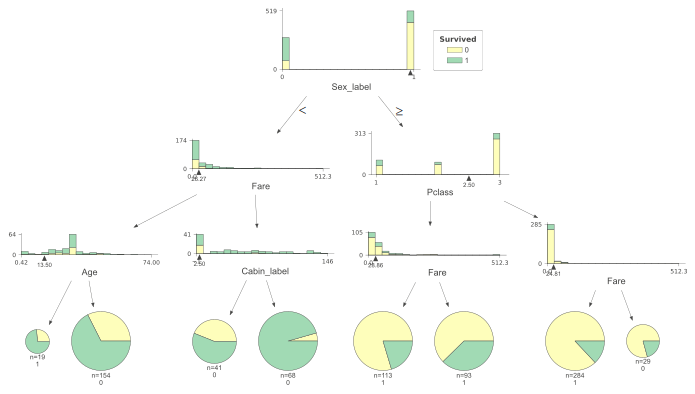

In [15]:
dtreeviz(tf_shadow)

### Prediction path

In [16]:
X = train[features].iloc[3]
X

Pclass             3.0000
Age                5.0000
Fare              19.2583
Sex_label          0.0000
Cabin_label       -1.0000
Embarked_label     0.0000
Name: 448, dtype: float64

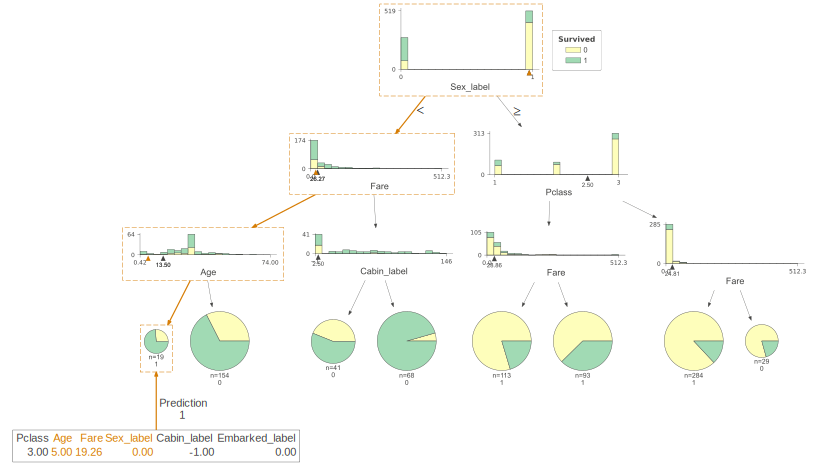

In [18]:
dtreeviz(tf_shadow, X=X)

### Visualisation samples

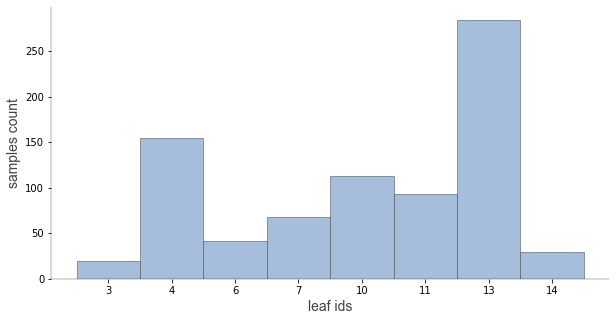

In [19]:
viz_leaf_samples(tf_shadow)

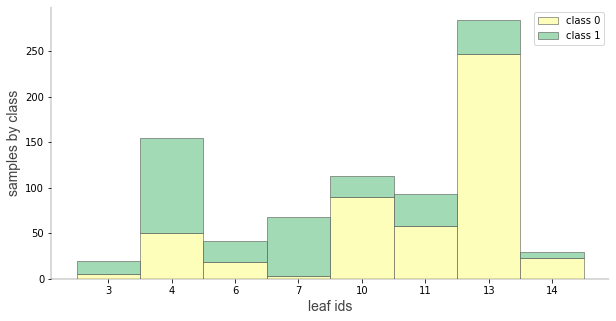

In [20]:
ctreeviz_leaf_samples(tf_shadow)

### Describe node samples

In [21]:
describe_node_sample(tf_shadow, node_id=4)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,154.000000,154.000000,154.000000,154.0,154.000000,154.000000
mean,2.642857,29.223797,13.999488,0.0,10.941558,1.538961
std,0.507185,8.882894,6.351997,0.0,37.043383,0.706026
min,1.000000,14.000000,7.225000,0.0,-1.000000,0.000000
25%,2.000000,24.000000,7.903100,0.0,-1.000000,1.000000
50%,3.000000,29.699118,13.000000,0.0,-1.000000,2.000000
75%,3.000000,31.000000,18.000000,0.0,-1.000000,2.000000
max,3.000000,63.000000,26.250000,0.0,145.000000,2.000000


### Explain prediction path

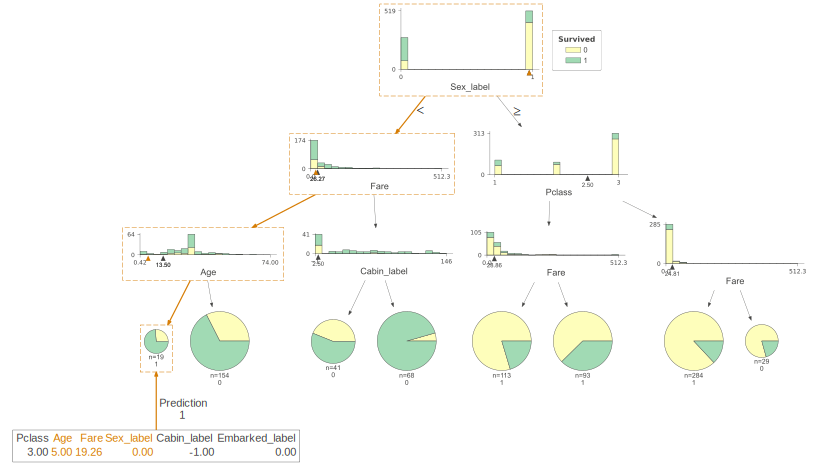

In [22]:
dtreeviz(tf_shadow, X=X)

In [23]:
X = train[features].iloc[10]
X

Pclass             3.00
Age               38.00
Fare               7.05
Sex_label          1.00
Cabin_label       -1.00
Embarked_label     2.00
Name: 465, dtype: float64

In [25]:
print(explain_prediction_path(tf_shadow, X, explanation_type="plain_english"))

2.5 <= Pclass 
Fare < 24.81
Sex_label in {1}  



# Regression

## Model training

In [26]:
random_seed = 1234
features_reg = ["Pclass", "Survived", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target_reg = "Age"
train_reg, test_reg = train_test_split(dataset[features_reg + [target_reg]], train_size=0.8, random_state=random_seed)


In [27]:
train_reg_ds = tf.keras.pd_dataframe_to_tf_dataset(train_reg, label=target_reg, task=Task.REGRESSION)
test_reg_ds = tf.keras.pd_dataframe_to_tf_dataset(test_reg, label=target_reg, task=Task.REGRESSION)

In [28]:
model_reg = tf.keras.RandomForestModel(num_trees=4, max_depth=4, random_seed = random_seed, bootstrap_training_dataset=False, sampling_with_replacement=False, task=Task.REGRESSION)
model_reg.fit(train_reg_ds)



Use /var/folders/yp/rczwnkhn6nn9mfcf0bgc61jh0000gn/T/tmpakdea8a6 as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.105756
Training model
Model trained in 0:00:00.003177
Compiling model
1/1 [==============================] - 0s 112ms/step


In [29]:
print(model_reg.evaluate(test_reg_ds))


1/1 [==============================] - 0s 48ms/step - loss: 0.0000e+00
0.0


## Model metadata discovery

In [30]:
print(tf.model_plotter.plot_model(model_reg, tree_idx=0))


<script src="https://d3js.org/d3.v6.min.js"></script>
<div id="tree_plot_e7e4a793f66f4ed8a7dd83e6908a3ceb"></div>
<script>
/*
 * Copyright 2021 Google LLC.
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     https://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

/**
 *  Plotting of decision trees generated by TF-DF.
 *
 *  A tree is a recursive structure of node objects.
 *  A node contains one or more of the following components:
 *
 *    - A value: Representing the output of the node. If the node is not a leaf,
 *      the value is only 

## dtreeviz - model interpretation

In [31]:
tf_reg_shadow = ShadowTensorflowTree(model_reg, tree_index=0, 
                             x_data=train_reg[features_reg], 
                             y_data=train_reg[target_reg], 
                             feature_names=features_reg, 
                             target_name=target_reg,
                             class_names=[0, 1])

### Tree structure

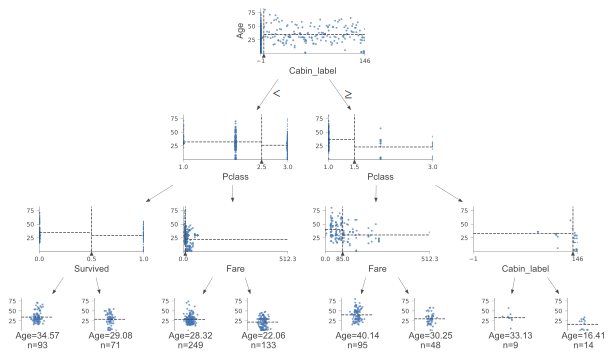

In [32]:
dtreeviz(tf_reg_shadow)

### Prediction path

In [33]:
X = train_reg[features_reg].iloc[3]
X

Pclass             3.0000
Survived           1.0000
Fare              56.4958
Sex_label          1.0000
Cabin_label       -1.0000
Embarked_label     2.0000
Name: 643, dtype: float64

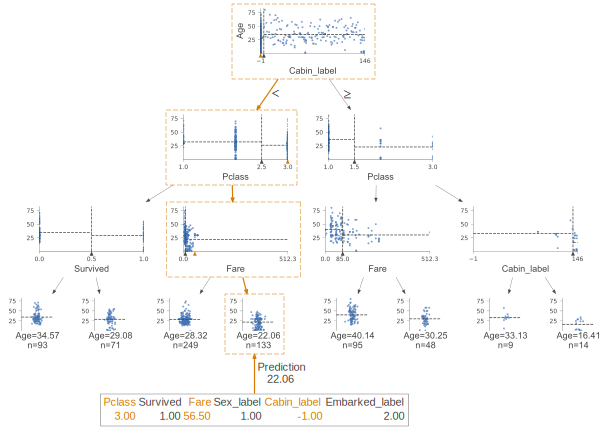

In [34]:
dtreeviz(tf_reg_shadow, X=X)

### Visualisation samples

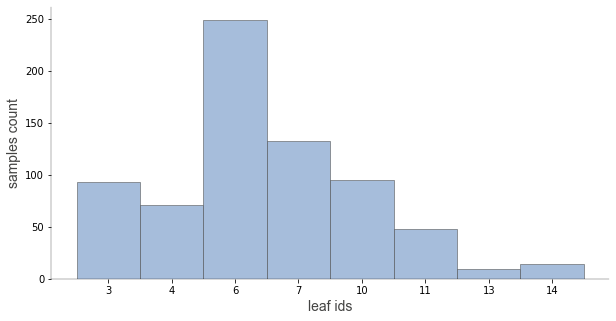

In [36]:
viz_leaf_samples(tf_reg_shadow)

### Describe node samples

In [37]:
describe_node_sample(tf_reg_shadow, node_id=4)

,Pclass,Survived,Fare,Sex_label,Cabin_label,Embarked_label
count,71.000000,71.0,71.000000,71.000000,71.0,71.000000
mean,1.774648,1.0,44.209215,0.197183,-1.0,1.633803
std,0.420788,0.0,69.307625,0.400704,0.0,0.779000
min,1.000000,1.0,10.500000,0.000000,-1.0,0.000000
25%,2.000000,1.0,15.875000,0.000000,-1.0,2.000000
50%,2.000000,1.0,26.000000,0.000000,-1.0,2.000000
75%,2.000000,1.0,33.000000,0.000000,-1.0,2.000000
max,2.000000,1.0,512.329200,1.000000,-1.0,2.000000


### Explain prediction path

In [38]:
X = train_reg[features_reg].iloc[10]
X

Pclass            3.00
Survived          0.00
Fare              7.25
Sex_label         1.00
Cabin_label      -1.00
Embarked_label    2.00
Name: 470, dtype: float64

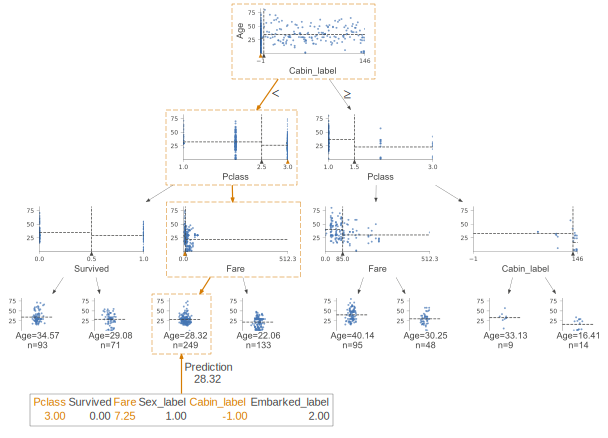

In [40]:
dtreeviz(tf_reg_shadow, X=X)

In [42]:
print(explain_prediction_path(tf_reg_shadow, X, explanation_type="plain_english"))

2.5 <= Pclass 
Fare < 9.71
Cabin_label < 3.5



### Leaf targets

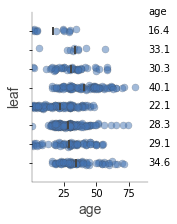

In [44]:
viz_leaf_target(tf_reg_shadow)

# Unit tests
This section was using during development phase and unit testing

In [51]:
from tensorflow_decision_forests.component.inspector import inspector as inspector_lib


In [52]:
random_state = 1234
dataset = pd.read_csv("../testing/testlib/models/fixtures/dataset_spark_tf.csv")
# features_clf = ["Pclass","Sex_label","Embarked_label", "Age_mean","SibSp","Parch","Fare"]
features_clf = ["Pclass","Age_mean"]
target_clf = "Survived"

In [54]:
train_clf = tf.keras.pd_dataframe_to_tf_dataset(dataset[features_clf + [target_clf]], label=target_clf)
model_clf = tf.keras.RandomForestModel(max_depth=3, random_seed = random_state)
model_clf.fit(train_clf)

Use /var/folders/yp/rczwnkhn6nn9mfcf0bgc61jh0000gn/T/tmpm2zwudsn as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.066875
Training model
Model trained in 0:00:00.018162
Compiling model
1/1 [==============================] - 0s 94ms/step


## HTML output

In [55]:
print(tf.model_plotter.plot_model(model_clf, tree_idx=0))


<script src="https://d3js.org/d3.v6.min.js"></script>
<div id="tree_plot_49b00fdf42e9451882c85651a65911e5"></div>
<script>
/*
 * Copyright 2021 Google LLC.
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     https://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

/**
 *  Plotting of decision trees generated by TF-DF.
 *
 *  A tree is a recursive structure of node objects.
 *  A node contains one or more of the following components:
 *
 *    - A value: Representing the output of the node. If the node is not a leaf,
 *      the value is only 

## Model metadata

In [56]:
tree_clf = model_clf.make_inspector().extract_tree(tree_idx=0)

In [57]:
dir(tree_clf)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_label_classes',
 '_root',
 'label_classes',
 'root']

In [58]:
tree_clf

Tree(NonLeafNode(condition=(Pclass >= 2.5; miss=False), pos_child=NonLeafNode(condition=(Age_mean >= 32.5; miss=False), pos_child=LeafNode(value=ProbabilityValue([0.9493670886075949, 0.05063291139240506],n=79.0), idx=3), neg_child=LeafNode(value=ProbabilityValue([0.6847058823529412, 0.31529411764705884],n=425.0), idx=2), value=ProbabilityValue([0.7261904761904762, 0.27380952380952384],n=504.0)), neg_child=NonLeafNode(condition=(Age_mean >= 15.5; miss=True), pos_child=LeafNode(value=ProbabilityValue([0.42696629213483145, 0.5730337078651685],n=356.0), idx=1), neg_child=LeafNode(value=ProbabilityValue([0.03225806451612903, 0.967741935483871],n=31.0), idx=0), value=ProbabilityValue([0.3953488372093023, 0.6046511627906976],n=387.0)), value=ProbabilityValue([0.5824915824915825, 0.4175084175084175],n=891.0)),label_classes={self.label_classes})

In [59]:
dir(model_clf)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_advanced_arguments',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build',
 '_build_input_shape',
 '_build_normalized_inputs',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_cal

In [60]:
model_clf.save_spec()

([{'Pclass': TensorSpec(shape=(None,), dtype=tf.int64, name='Pclass'),
   'Age_mean': TensorSpec(shape=(None,), dtype=tf.float32, name='Age_mean')}],
 {})

In [61]:
tree_clf.root.value.probability

[0.5824915824915825, 0.4175084175084175]

In [62]:
np.argmax(tree_clf.root.value.probability)

0

In [63]:
model_clf.summary()

Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	Age_mean
	Pclass

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.  "__LABEL"  2.000000 ################
    2. "Age_mean"  1.015000 ########
    3.   "Pclass"  0.000000 

Variable Importance: NUM_AS_ROOT:
    1. "Pclass" 300.000000 

Variable Importance: NUM_NODES:
    1. "Age_mean" 591.000000 ################
    2.   "Pclass" 309.000000 

Variable Importance: SUM_SCORE:
    1.   "Pclass" 14197.157071 ################
    2. "Age_mean" 7308.154264 



Winner take all: true
Out-of-bag evaluation: accuracy:0.656566 logloss:4.28289
Number of trees: 300
Total number of nodes: 2100

Number of nodes by tree:
Count: 300